In [142]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
path = 'D:/dataset/playground_Sep2022'
test = pd.read_csv(path + '/test.csv', parse_dates=["date"]).copy()
train = pd.read_csv(path + '/train.csv', parse_dates=["date"]).copy()
origin_train = train.copy()
sample_submission = pd.read_csv(path + '/sample_submission.csv').copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


In [144]:
display(train.head())
display(test.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [145]:
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count



def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel="");

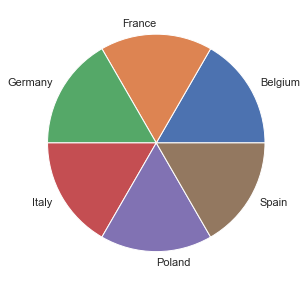

In [146]:
plot_and_display_valuecounts(train, 'country')

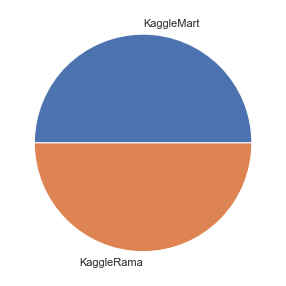

In [147]:
plot_and_display_valuecounts(train, 'store')

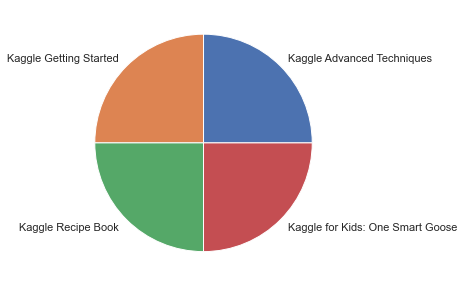

In [148]:
plot_and_display_valuecounts(train, 'product')

In [149]:
train.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

This gives us 48 univariate time series all of length 1461.
This data is equal amounts

In [151]:
# country, store, product 1주 간격으로 재정렬
weekly_df = train.groupby(['country', 'store','product', pd.Grouper(key = 'date', freq = 'W')])["num_sold"].sum().rename("num_sold").reset_index()

# country, store, product 1달 간격으로 재정렬
monthly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01     13345
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-02-01     12556
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-03-01     14137
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-04-01     14575
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-05-01     14338

In [153]:
def plot_all(df):
    f, axes = plt.subplots(2, 2, figsize = (20, 15), sharex = True, sharey = True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.set(font_scale = 1)
        sns.lineplot(data = plot_df, x = 'date', y = 'num_sold', hue = 'country', style = 'store', ax = axes[n // 2, n% 2])
        axes[n // 2, n % 2].set_title("Product: "+str(prod))

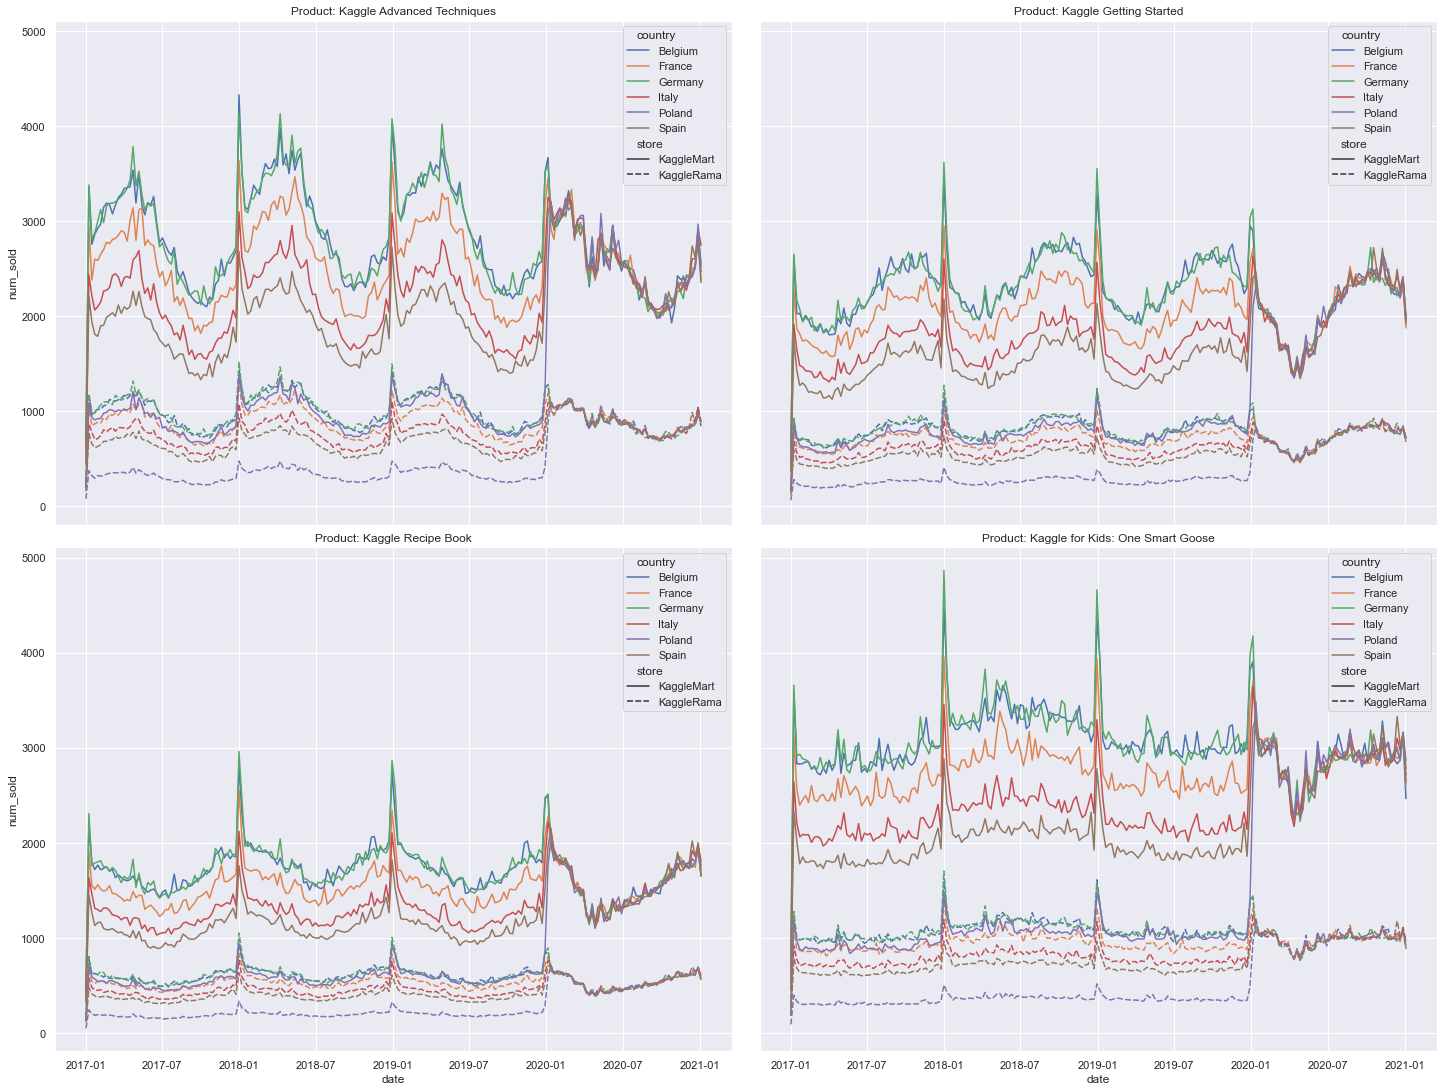

In [154]:
plot_all(weekly_df)

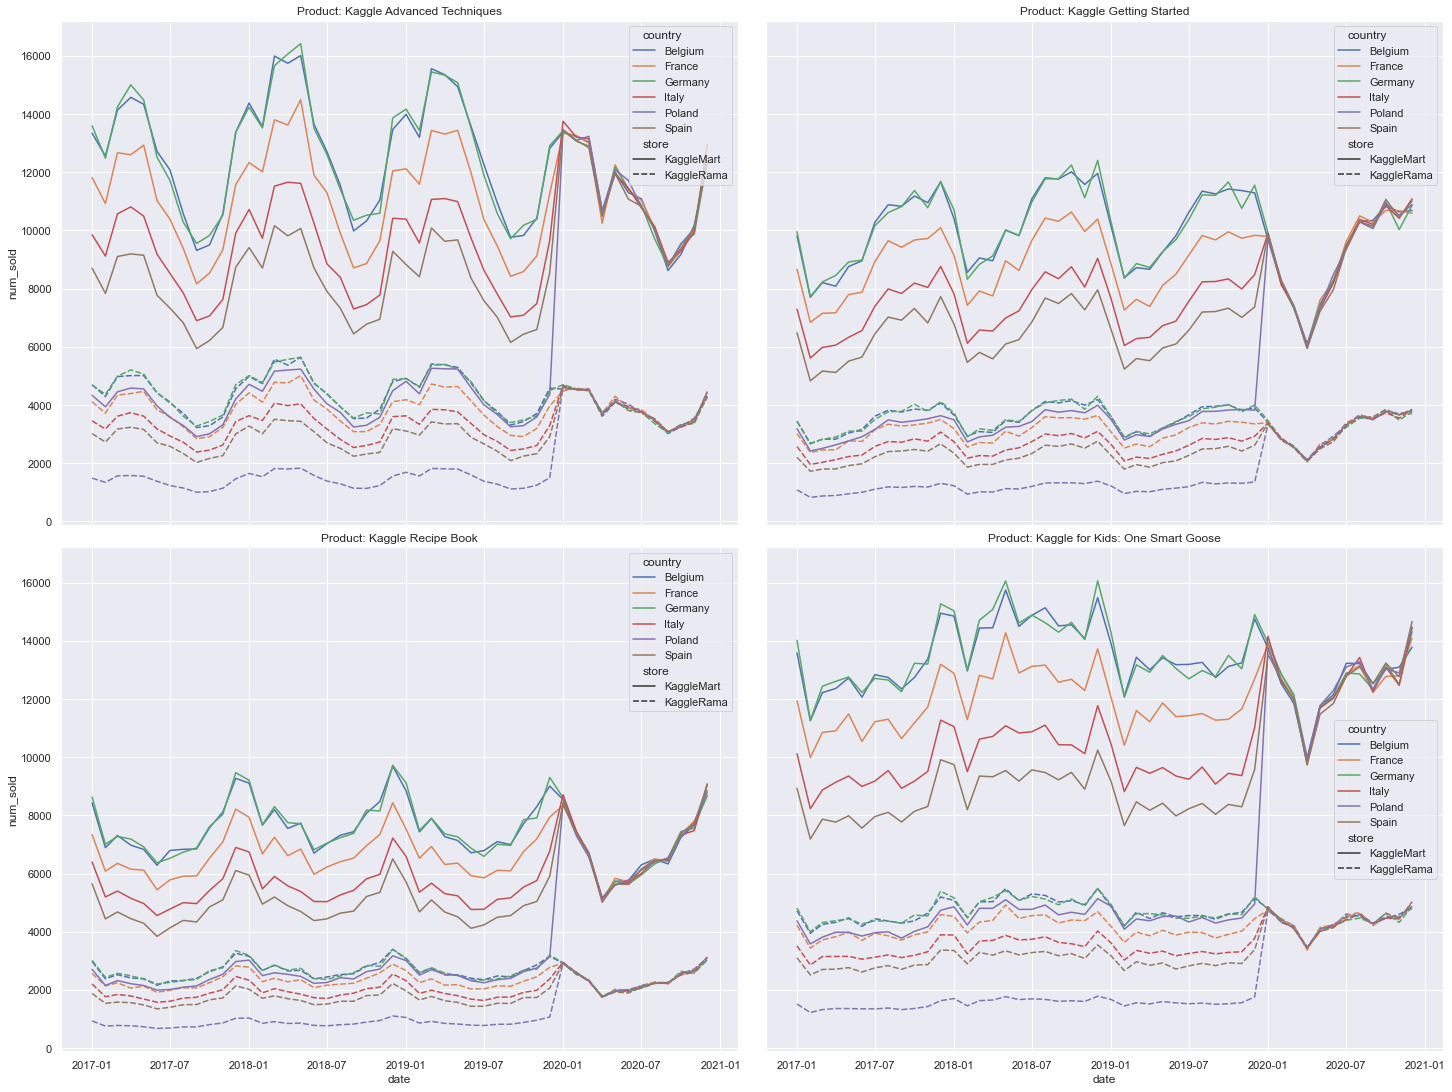

In [155]:
plot_all(monthly_df)

In [157]:
def make_radio(df, index):
    radio = (df.groupby(["date",index])["num_sold"].sum() / df.groupby(["date"])["num_sold"].sum()).reset_index()
    weights = df.groupby(index)['num_sold'].sum() / df['num_sold'].sum()
    return radio, weights

In [158]:
store_ratio_over_time, store_weights = make_radio(train, "store")
store_ratio_over_time

date       store  num_sold
0    2017-01-01  KaggleMart  0.736972
1    2017-01-01  KaggleRama  0.263028
2    2017-01-02  KaggleMart  0.739679
3    2017-01-02  KaggleRama  0.260321
4    2017-01-03  KaggleMart  0.741823
...         ...         ...       ...
2917 2020-12-29  KaggleRama  0.263032
2918 2020-12-30  KaggleMart  0.741631
2919 2020-12-30  KaggleRama  0.258369
2920 2020-12-31  KaggleMart  0.738594
2921 2020-12-31  KaggleRama  0.261406

[2922 rows x 3 columns]

In [159]:
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

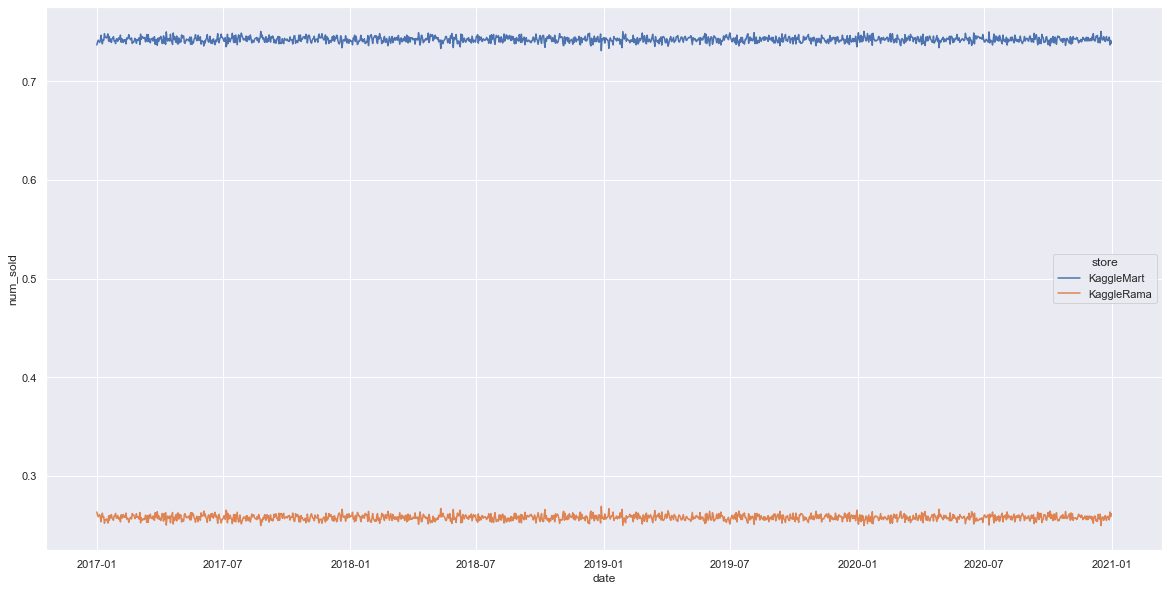

In [160]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(data = store_ratio_over_time, x = 'date', y = 'num_sold', hue = 'store')
ax.set_label("Proportion of sales");

In [162]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = store_weights.loc["KaggleMart"] / store_weights
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

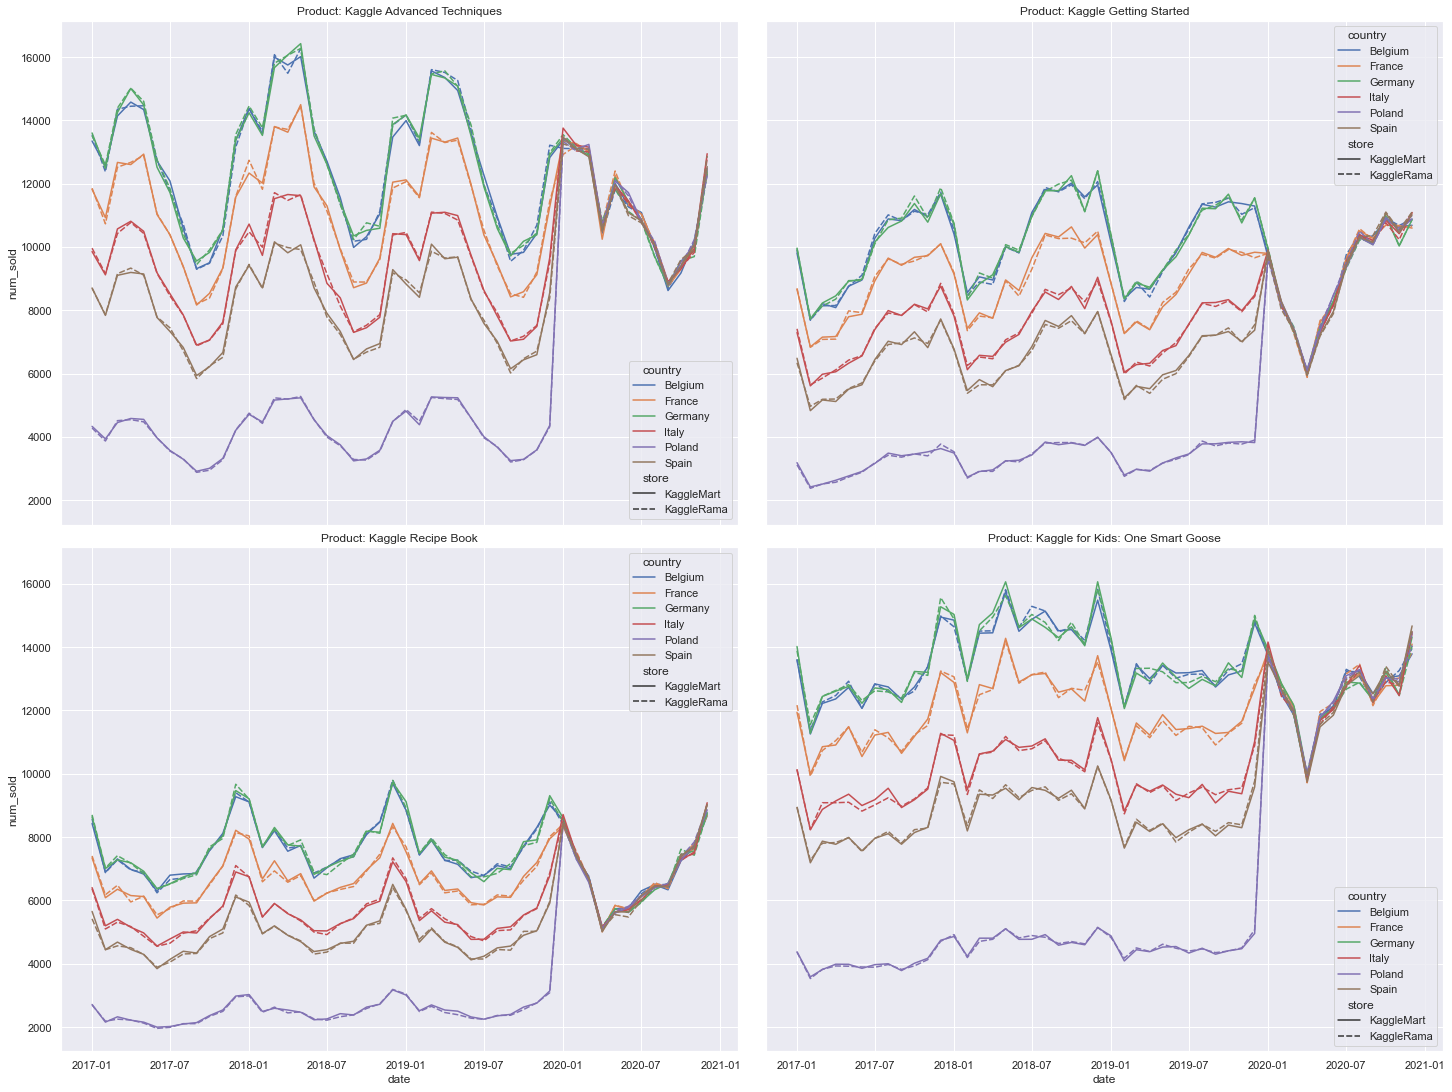

In [163]:
plot_adjusted_store(monthly_df)

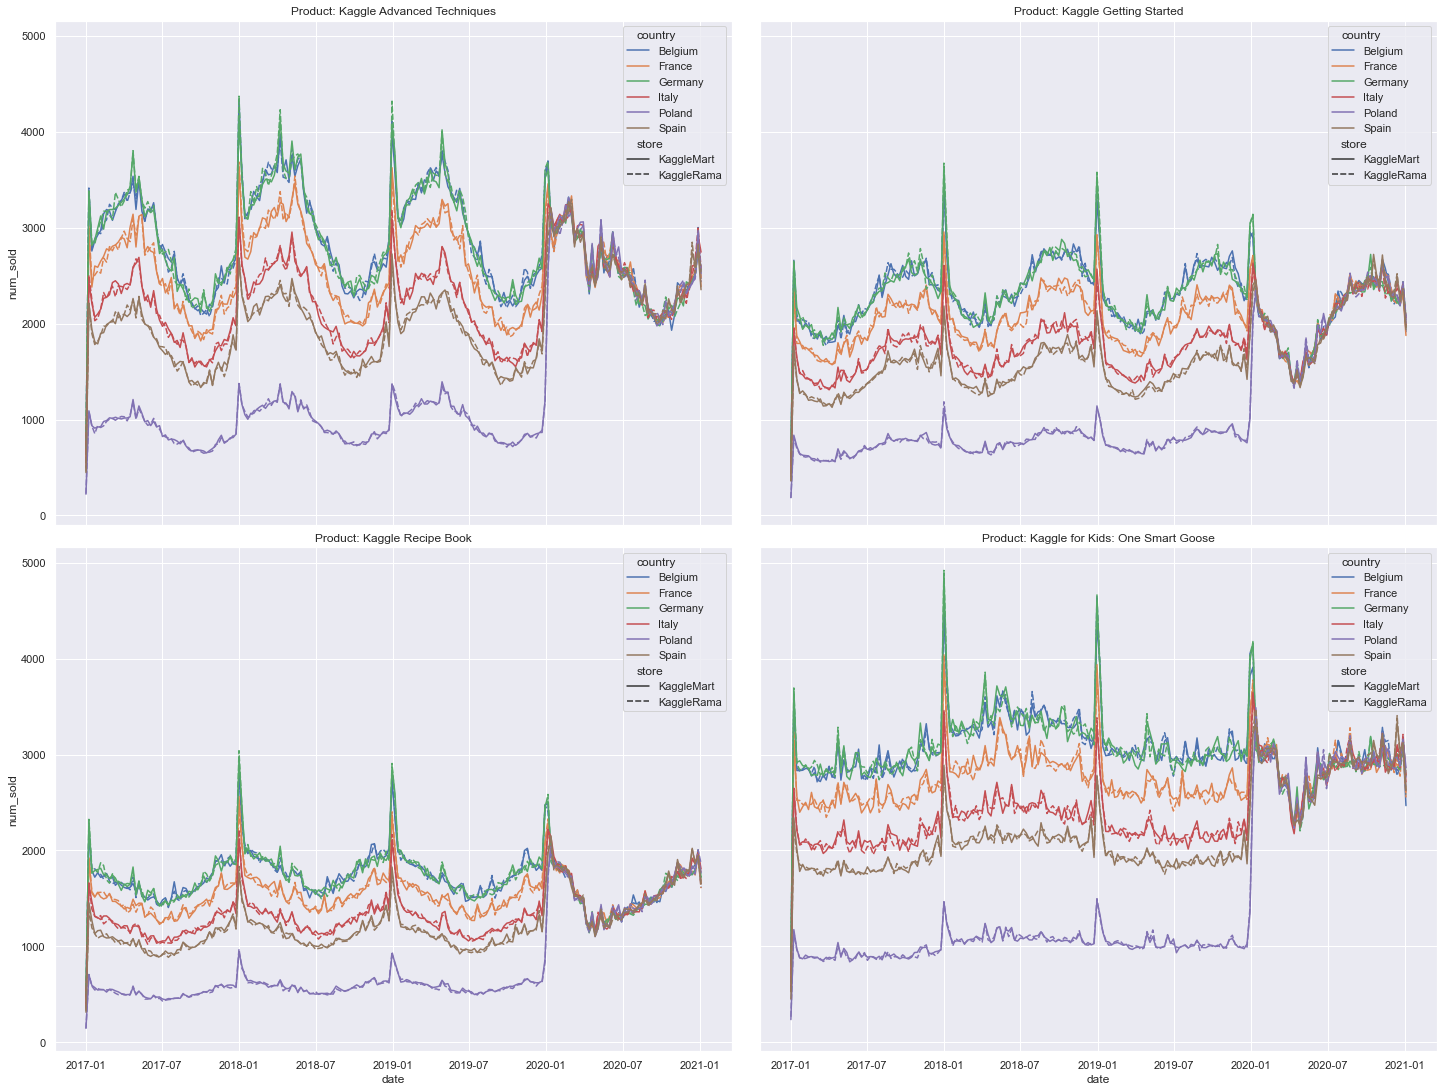

In [164]:
plot_adjusted_store(weekly_df)

In [166]:
country_ratio_over_time, country_weights = make_radio(train, "country")
country_ratio_over_time

date  country  num_sold
0    2017-01-01  Belgium  0.216258
1    2017-01-01   France  0.191441
2    2017-01-01  Germany  0.223880
3    2017-01-01    Italy  0.158351
4    2017-01-01   Poland  0.069958
...         ...      ...       ...
8761 2020-12-31   France  0.159591
8762 2020-12-31  Germany  0.172803
8763 2020-12-31    Italy  0.178028
8764 2020-12-31   Poland  0.172744
8765 2020-12-31    Spain  0.159474

[8766 rows x 3 columns]

In [167]:
country_weights = train.loc[train["date"] < "2020-01-01"].groupby('country')['num_sold'].sum() / train.loc[train["date"] < "2020-01-01", 'num_sold'].sum()
country_weights

country
Belgium    0.218930
France     0.191360
Germany    0.219586
Italy      0.159383
Poland     0.071348
Spain      0.139393
Name: num_sold, dtype: float64

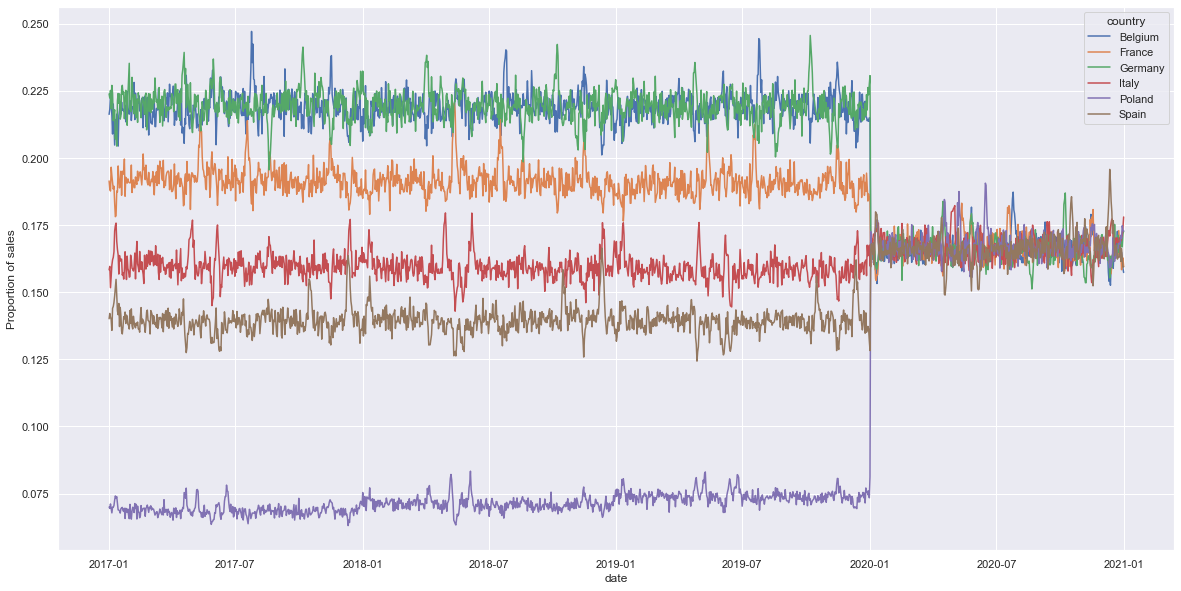

In [168]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
ax.set_ylabel("Proportion of sales");

In [170]:
train

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques       663  
1                Kaggle Getting Started       615  
2                    Kaggle Recipe Book       480  
3      Kaggle for Kids: One Smart Goose       710  
4            Kaggle Advanced Techniques       240  
...                                 ...       ...  
70123  Kaggle for Kids: One Smart Goose       614  
70124        Kaggle Advanced Techniques       215  
70125            Kaggle Getting Started       158  
70126                Kaggle Recipe Book       135  
70127  Kaggle for Kids: One Smart Goose       202  

[70128 rows x 6 columns]

In [106]:
def plot_adjust_country(df):
    new_df = df.copy()
    
    weights = country_weights.loc["Belgium"] / country_weights
    
    for country in weights.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  weights[country]
    #plot_country_product(new_df)
    plot_all(new_df)

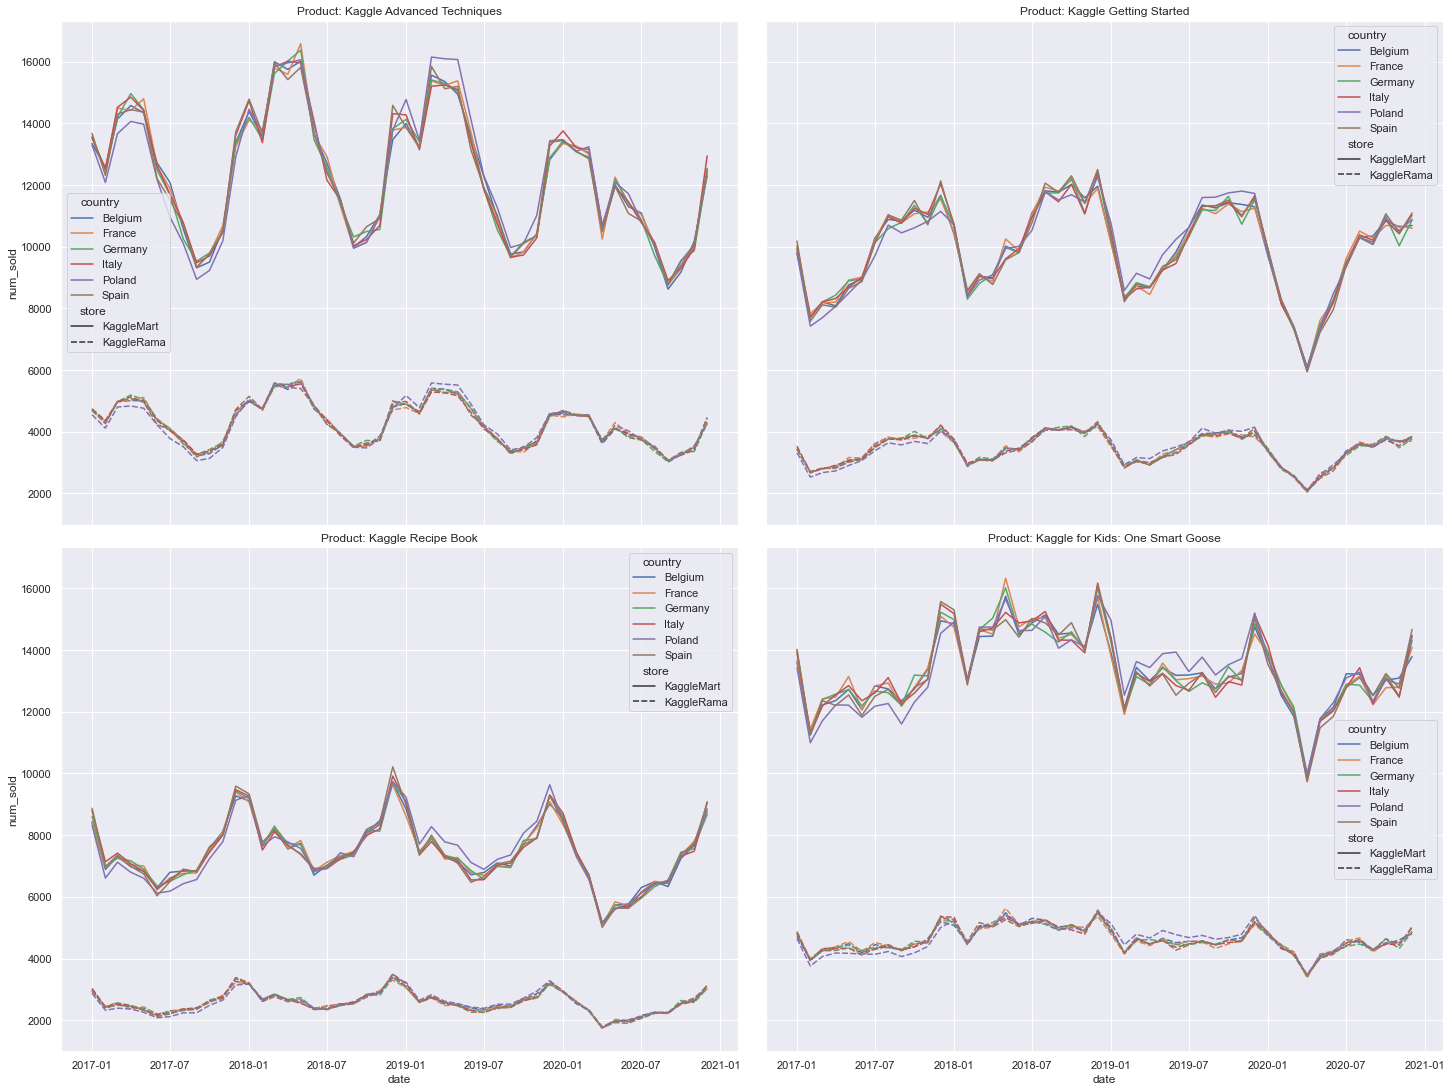

In [110]:
plot_adjust_country(monthly_df)

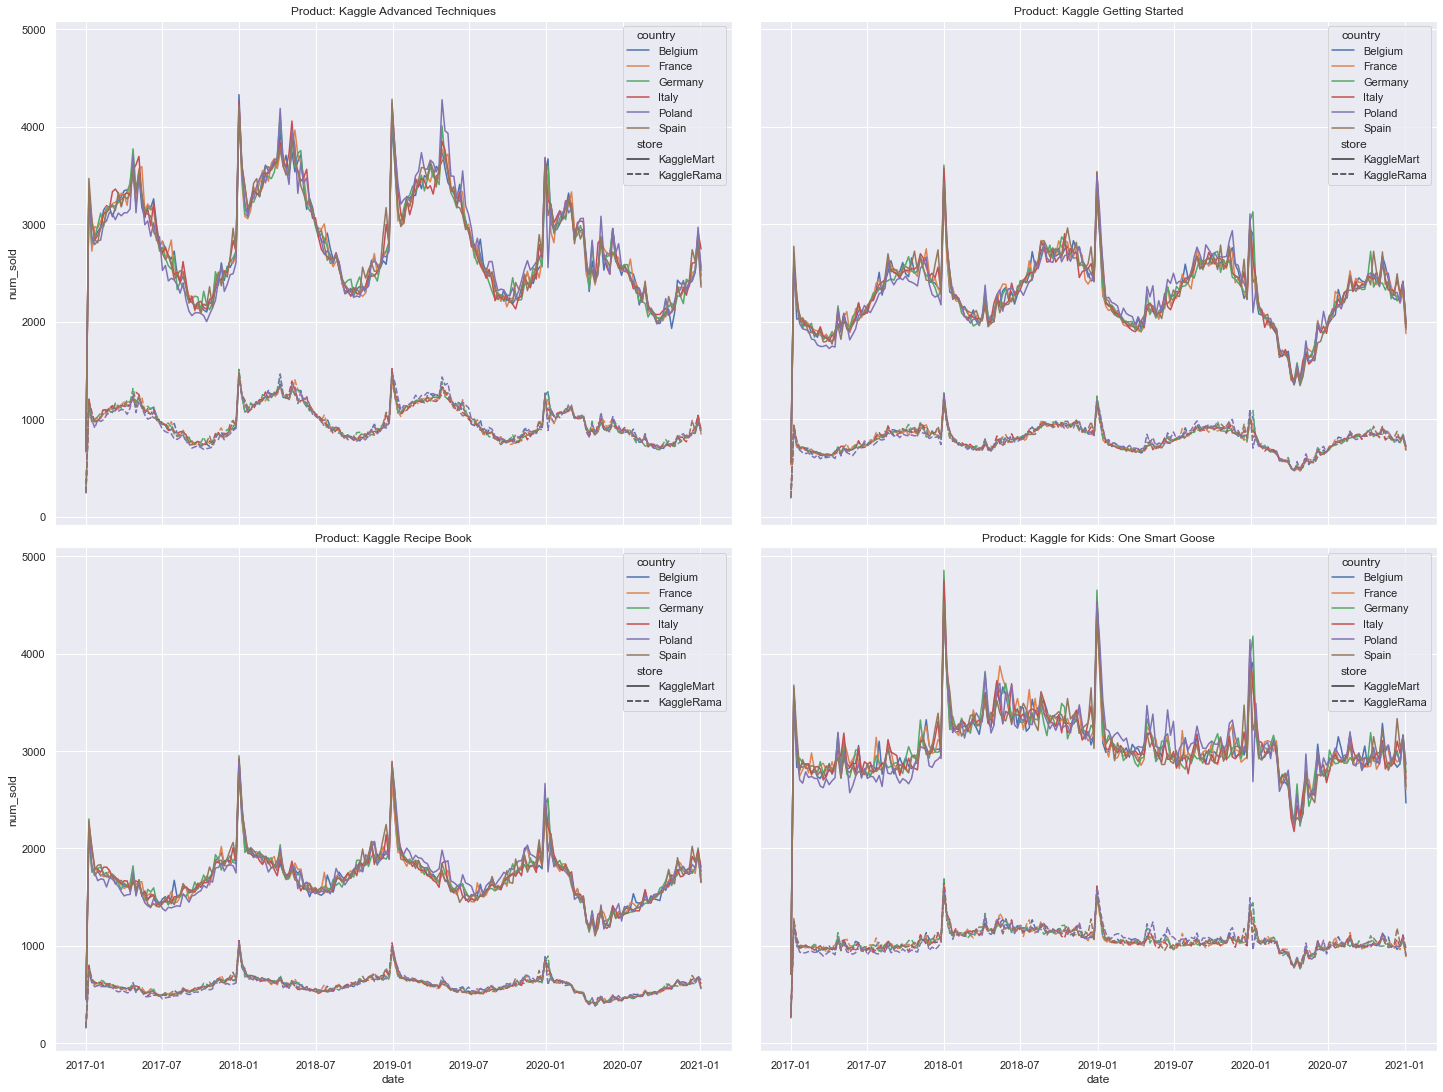

In [111]:
plot_adjust_country(weekly_df)

In [114]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df

date                           product  num_sold
0    2017-01-01        Kaggle Advanced Techniques      4267
1    2017-01-01            Kaggle Getting Started      3492
2    2017-01-01                Kaggle Recipe Book      2900
3    2017-01-01  Kaggle for Kids: One Smart Goose      4693
4    2017-01-02        Kaggle Advanced Techniques      3242
...         ...                               ...       ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose      5699
5840 2020-12-31        Kaggle Advanced Techniques      4968
5841 2020-12-31            Kaggle Getting Started      3780
5842 2020-12-31                Kaggle Recipe Book      3301
5843 2020-12-31  Kaggle for Kids: One Smart Goose      4982

[5844 rows x 3 columns]

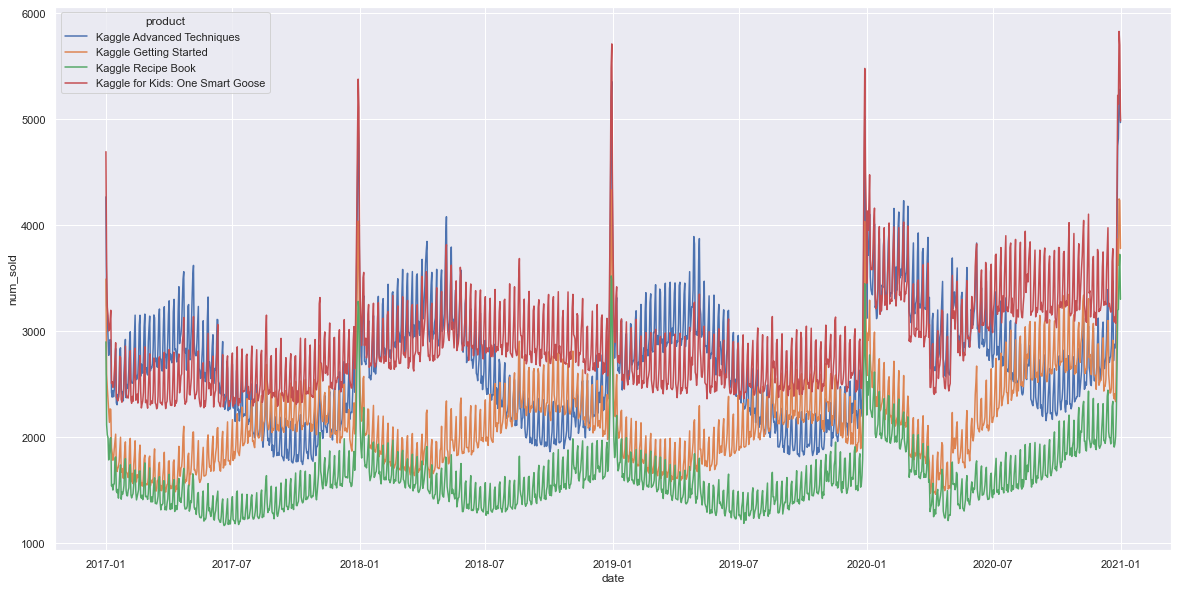

In [115]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

In [116]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

date                           product    ratios
0 2017-01-01        Kaggle Advanced Techniques  0.277944
1 2017-01-01            Kaggle Getting Started  0.227462
2 2017-01-01                Kaggle Recipe Book  0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose  0.305693

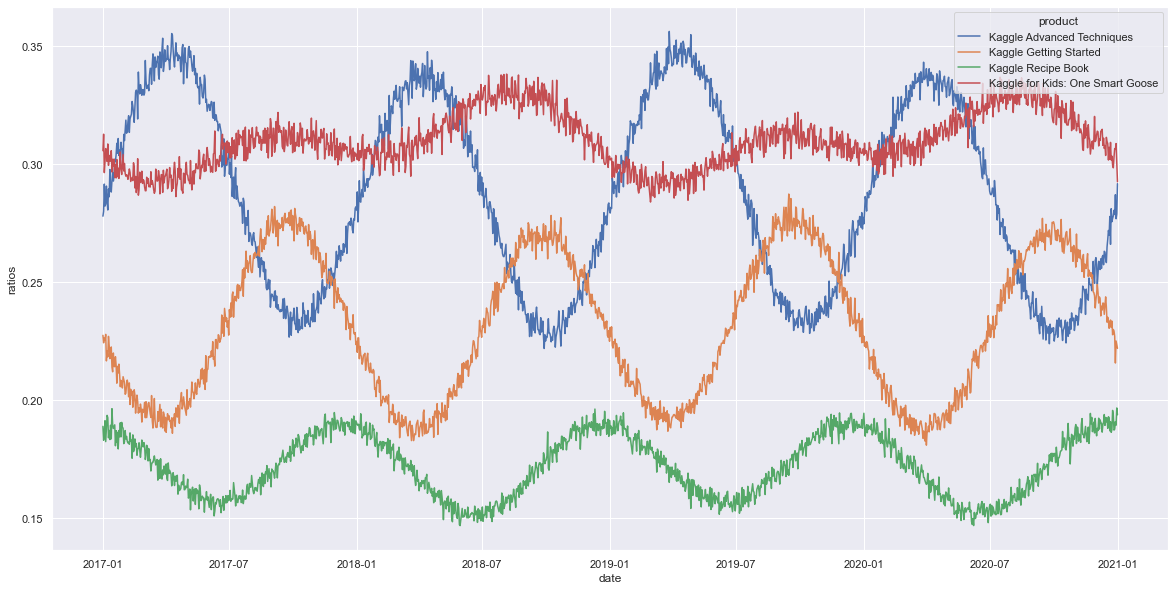

In [118]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

In [124]:
train = train.groupby(["date"])["num_sold"].sum().reset_index()

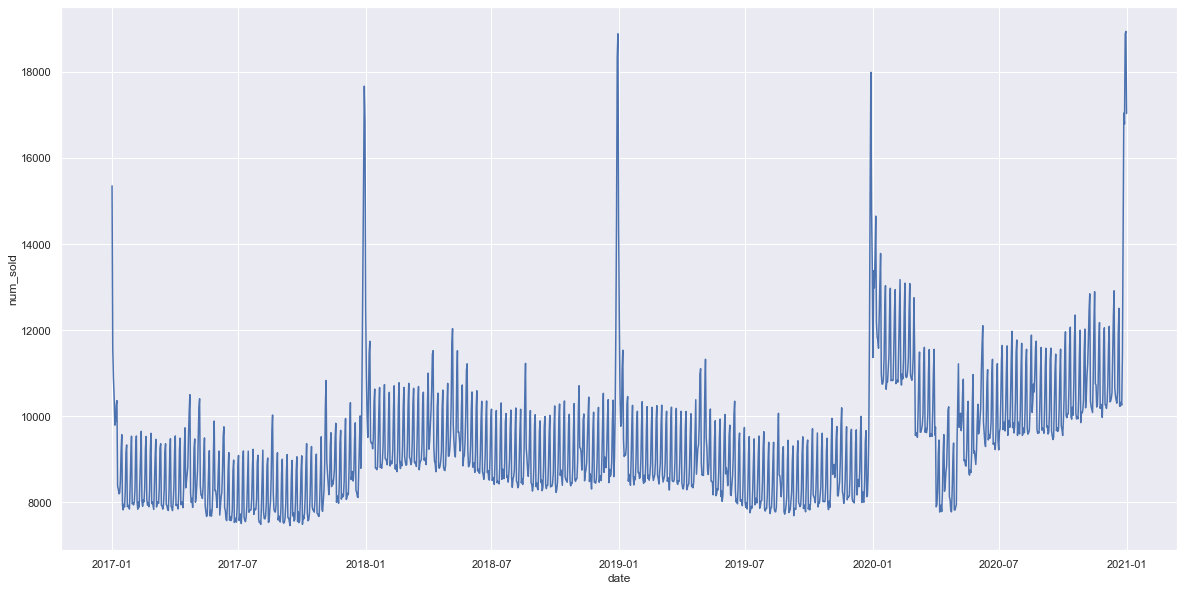

In [125]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train, x="date", y="num_sold");

In [126]:
weekly_df = train.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

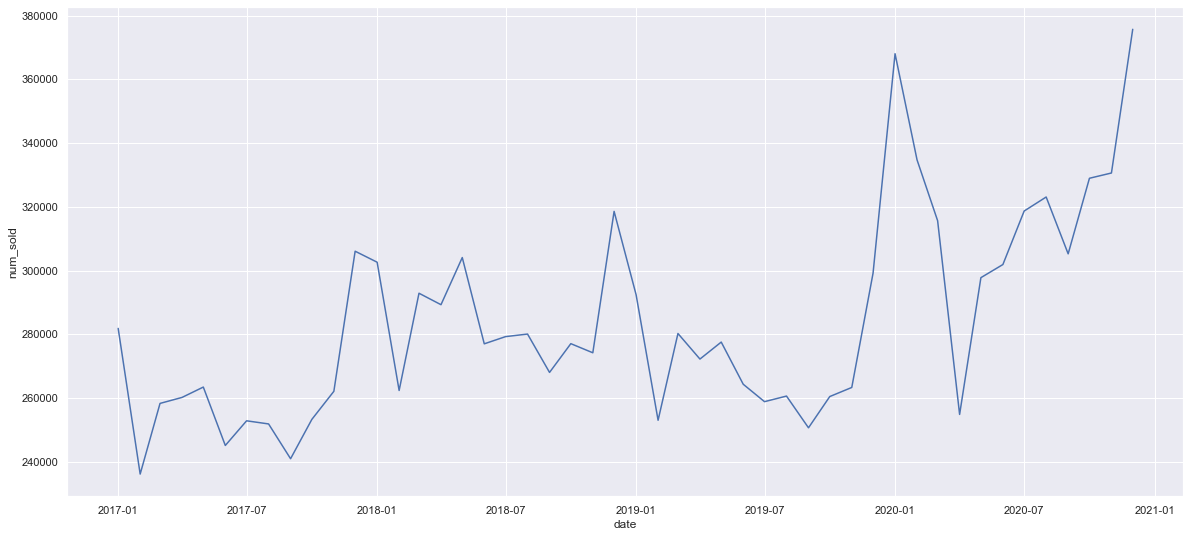

In [127]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=monthly_df, x="date", y="num_sold");

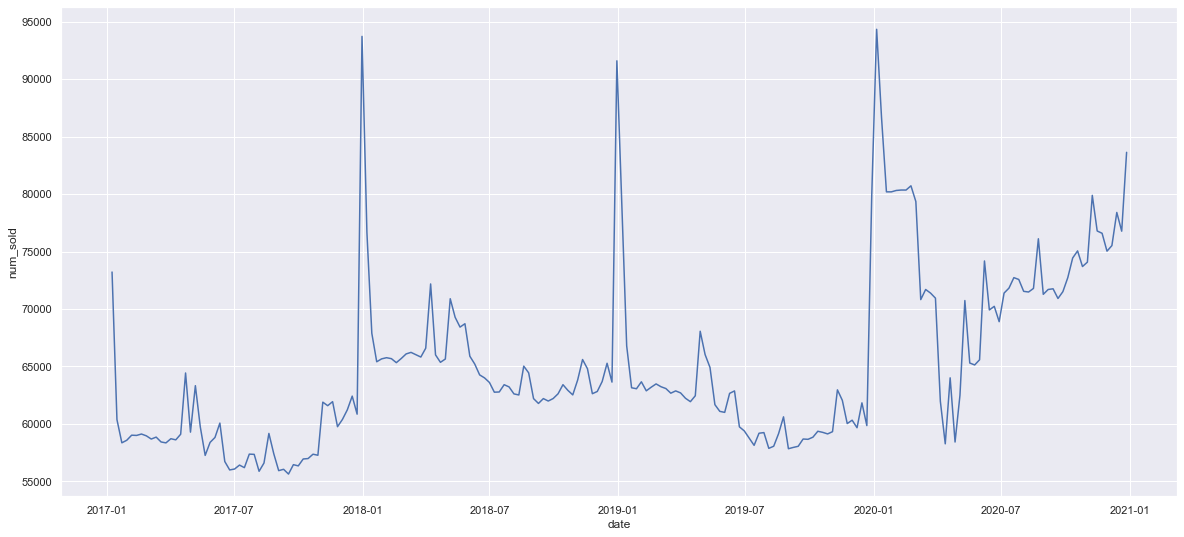

In [128]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=weekly_df[1:-1], x="date", y="num_sold");

In [134]:
def plot_seasonality(df, x_axis):
    
    #remove the leap year date
#     df = df.loc[df["date"] != "2020-02-29"].copy()

    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
#     df["day_of_year"] = df.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)
#     df['day_of_year'] = df.apply(lambda x: x["day_of_year"]-1, axis = 1)
        
    df_no_2020 = df.loc[df["date"] < "2020-01-01"]

    f,axes = plt.subplots(2,1,figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y="num_sold", ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y="num_sold", ax=axes[1]);
    axes[0].set_title("{} Seasonality - all years".format(x_axis))
    axes[1].set_title("{} Seasonality - not including 2020".format(x_axis))

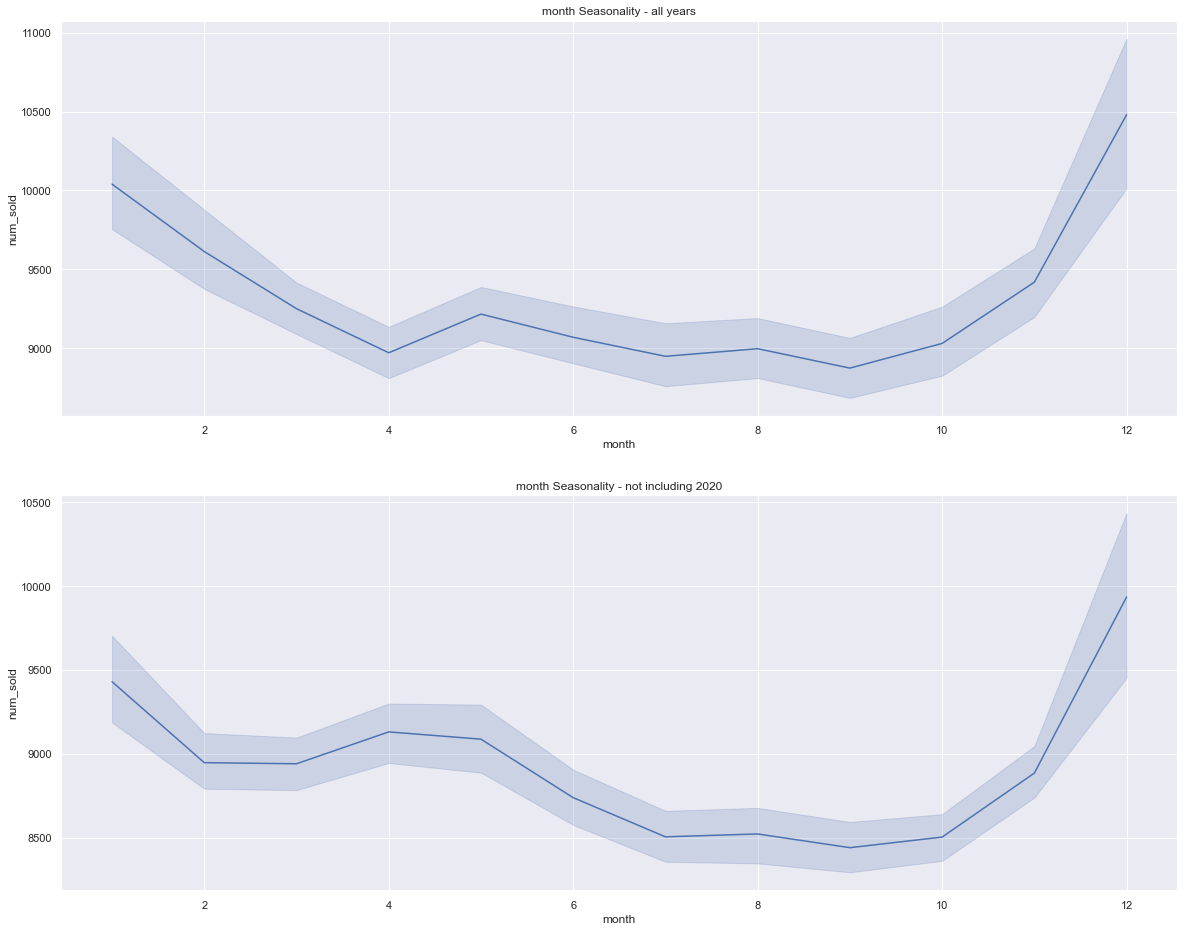

In [135]:
plot_seasonality(train, "month")

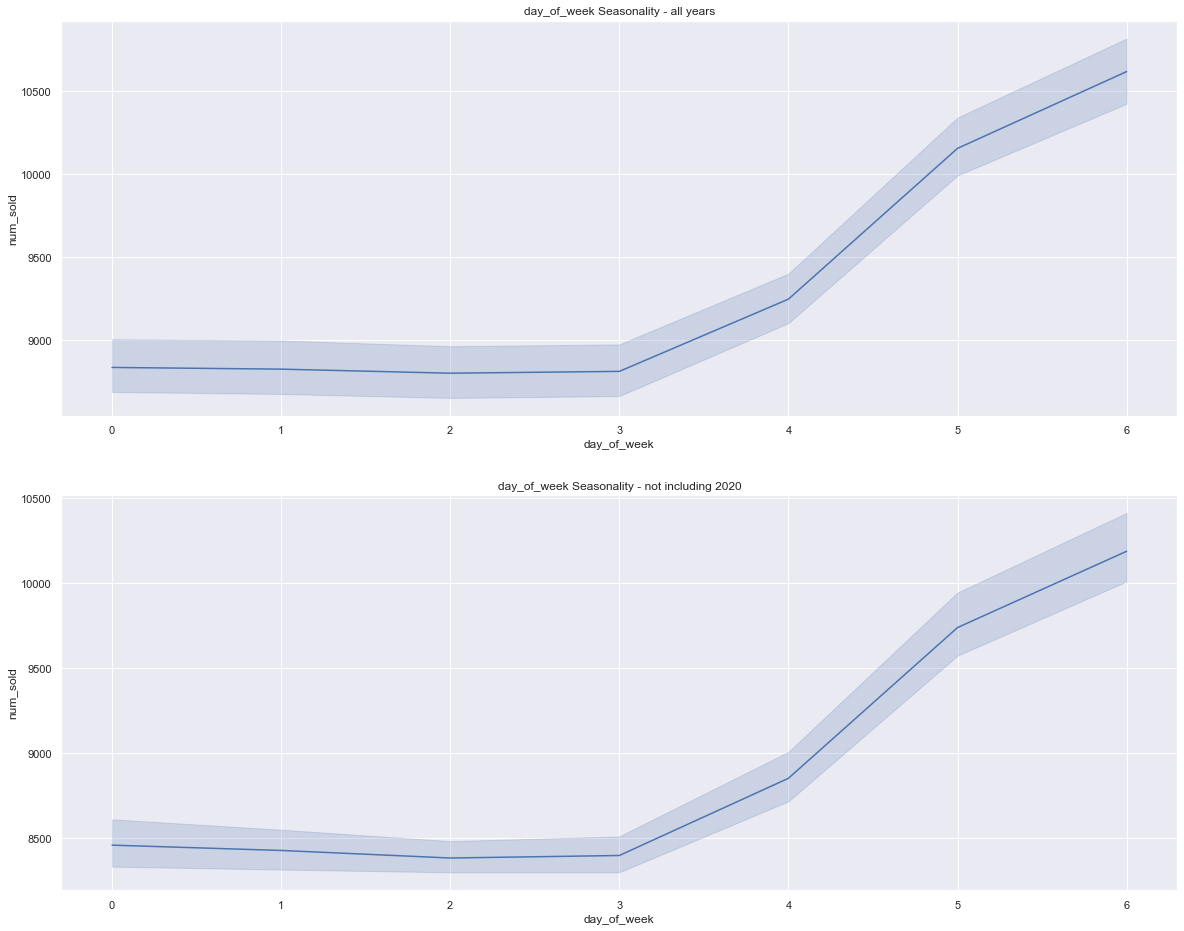

In [140]:
plot_seasonality(train, "day_of_week")

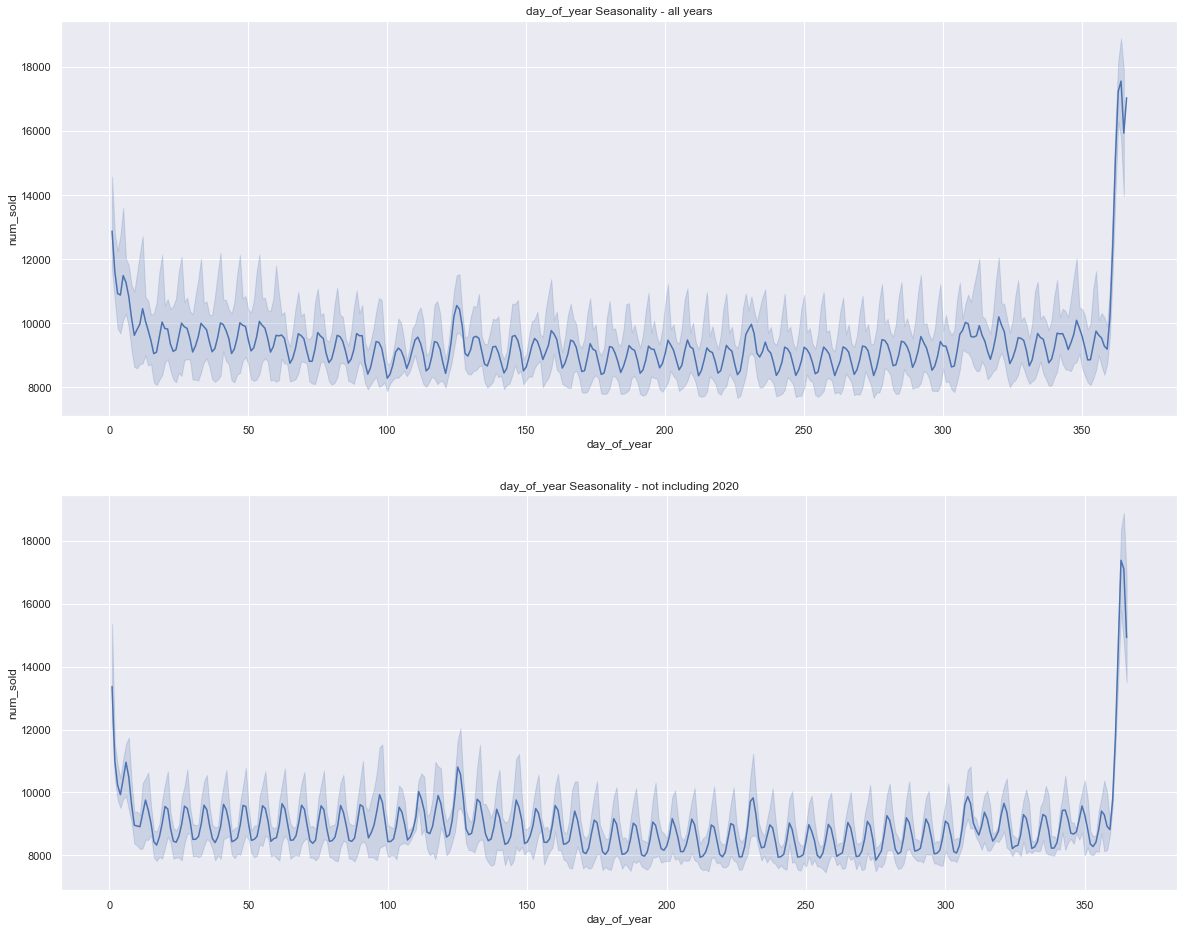

In [137]:
plot_seasonality(train_df, "day_of_year")

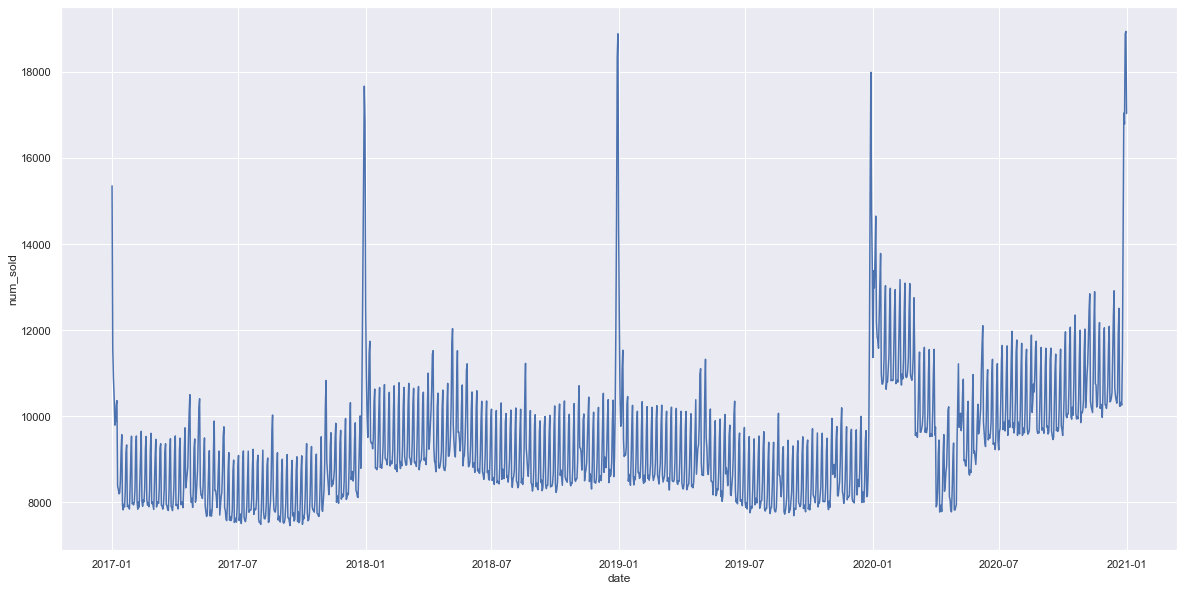

In [139]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train, x="date", y="num_sold");

In [141]:
train

date  num_sold  month  day_of_week  day_of_year
0    2017-01-01     15352      1            6            1
1    2017-01-02     11578      1            0            2
2    2017-01-03     10884      1            1            3
3    2017-01-04     10445      1            2            4
4    2017-01-05      9795      1            3            5
...         ...       ...    ...          ...          ...
1456 2020-12-27     17042     12            6          362
1457 2020-12-28     16789     12            0          363
1458 2020-12-29     18876     12            1          364
1459 2020-12-30     18938     12            2          365
1460 2020-12-31     17031     12            3          366

[1461 rows x 5 columns]

In [83]:
from sklearn.preprocessing import LabelEncoder
def change_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    
    data['country'] = LabelEncoder().fit_transform(data['country'])
    data['store'] = LabelEncoder().fit_transform(data['store'])
    data['product'] = LabelEncoder().fit_transform(data['product'])
    return data

train_change = change_data(train)
test_change = change_data(test)
train_change

row_id       date  country  store  product  num_sold  year  month  day  \
0           0 2017-01-01        0      0        0       663  2017      1    1   
1           1 2017-01-01        0      0        1       615  2017      1    1   
2           2 2017-01-01        0      0        2       480  2017      1    1   
3           3 2017-01-01        0      0        3       710  2017      1    1   
4           4 2017-01-01        0      1        0       240  2017      1    1   
...       ...        ...      ...    ...      ...       ...   ...    ...  ...   
70123   70123 2020-12-31        5      0        3       614  2020     12   31   
70124   70124 2020-12-31        5      1        0       215  2020     12   31   
70125   70125 2020-12-31        5      1        1       158  2020     12   31   
70126   70126 2020-12-31        5      1        2       135  2020     12   31   
70127   70127 2020-12-31        5      1        3       202  2020     12   31   

       dayofweek  quarter  
0              6        1  
1              6        1  
2              6        1  
3              6        1  
4              6        1  
...          ...      ...  
70123          3        4  
70124          3        4  
70125          3        4  
70126          3        4  
70127          3        4  

[70128 rows x 11 columns]

In [84]:
test_change

row_id       date  country  store  product  year  month  day  \
0       70128 2021-01-01        0      0        0  2021      1    1   
1       70129 2021-01-01        0      0        1  2021      1    1   
2       70130 2021-01-01        0      0        2  2021      1    1   
3       70131 2021-01-01        0      0        3  2021      1    1   
4       70132 2021-01-01        0      1        0  2021      1    1   
...       ...        ...      ...    ...      ...   ...    ...  ...   
17515   87643 2021-12-31        5      0        3  2021     12   31   
17516   87644 2021-12-31        5      1        0  2021     12   31   
17517   87645 2021-12-31        5      1        1  2021     12   31   
17518   87646 2021-12-31        5      1        2  2021     12   31   
17519   87647 2021-12-31        5      1        3  2021     12   31   

       dayofweek  quarter  
0              4        1  
1              4        1  
2              4        1  
3              4        1  
4              4        1  
...          ...      ...  
17515          4        4  
17516          4        4  
17517          4        4  
17518          4        4  
17519          4        4  

[17520 rows x 10 columns]

In [85]:
train_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   row_id     70128 non-null  int64         
 1   date       70128 non-null  datetime64[ns]
 2   country    70128 non-null  int64         
 3   store      70128 non-null  int64         
 4   product    70128 non-null  int64         
 5   num_sold   70128 non-null  int64         
 6   year       70128 non-null  int64         
 7   month      70128 non-null  int64         
 8   day        70128 non-null  int64         
 9   dayofweek  70128 non-null  int64         
 10  quarter    70128 non-null  int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 5.9 MB


이 챌린지에서는 6개국에 있는 두 개의 경쟁 매장에서 4개 품목에 대한 1년 동안의 매출을 예측합니다. 이 데이터 세트는 완전히 허구이지만 실제 데이터에서 볼 수 있는 많은 효과(예: 주말 및 공휴일 효과, 계절성 등)가 포함되어 있습니다. 2021년 동안 책 판매를 예측하는 어려운 작업이 주어집니다.

In [86]:
X_train_drop = train_change.drop(['num_sold', 'date', 'row_id'], axis = 1)
X_train_drop_ = train_change.drop(['num_sold', 'row_id'], axis = 1)

y_train_drop = train_change['num_sold']
test_drop = test_change.drop(['date', 'row_id'], axis = 1)

In [87]:
X_train_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2017      1    1          6        1
1            0      0        1  2017      1    1          6        1
2            0      0        2  2017      1    1          6        1
3            0      0        3  2017      1    1          6        1
4            0      1        0  2017      1    1          6        1
...        ...    ...      ...   ...    ...  ...        ...      ...
70123        5      0        3  2020     12   31          3        4
70124        5      1        0  2020     12   31          3        4
70125        5      1        1  2020     12   31          3        4
70126        5      1        2  2020     12   31          3        4
70127        5      1        3  2020     12   31          3        4

[70128 rows x 8 columns]

In [88]:
test_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2021      1    1          4        1
1            0      0        1  2021      1    1          4        1
2            0      0        2  2021      1    1          4        1
3            0      0        3  2021      1    1          4        1
4            0      1        0  2021      1    1          4        1
...        ...    ...      ...   ...    ...  ...        ...      ...
17515        5      0        3  2021     12   31          4        4
17516        5      1        0  2021     12   31          4        4
17517        5      1        1  2021     12   31          4        4
17518        5      1        2  2021     12   31          4        4
17519        5      1        3  2021     12   31          4        4

[17520 rows x 8 columns]

In [89]:
X_train_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2017      1    1          6        1
1            0      0        1  2017      1    1          6        1
2            0      0        2  2017      1    1          6        1
3            0      0        3  2017      1    1          6        1
4            0      1        0  2017      1    1          6        1
...        ...    ...      ...   ...    ...  ...        ...      ...
70123        5      0        3  2020     12   31          3        4
70124        5      1        0  2020     12   31          3        4
70125        5      1        1  2020     12   31          3        4
70126        5      1        2  2020     12   31          3        4
70127        5      1        3  2020     12   31          3        4

[70128 rows x 8 columns]

In [90]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=train, x=X_train['store'], y=y_train, hue=X_train['date'])
# ax.legend().remove()
# plt.title('Product distribution grouped by country')
# plt.show()

In [91]:
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=train, x=X_train['product'], y=y_train, hue=X_train['country'])
# ax.legend().remove()
# ax.set(xticklabels = [])
# plt.title('Product distribution grouped by country')
# plt.show()

In [92]:
# fig, ax = plt.subplots(4, 1, figsize=(18, 20))
# ax = ax.flatten()

# for i, product in enumerate(train['product'].unique()):
#     subset = train[train['product'] == product]
#     sns.lineplot(ax=ax[i], data=subset.groupby(['date','country']).sum(), x='date', y='num_sold', hue='country')
#     plt.ylim([0,1400])
    
#     ax[i].set_title(product)
#     ax[i].set(xlabel = None)
    
#     ax[i].legend(loc='upper right')
#     if i!=2:
#         ax[i].legend().remove()

# fig.tight_layout()

In [93]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [98]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_drop, y_train_, random_state=42, shuffle = False)
X_train = X_train_drop
y_train = y_train_drop
X_train_time, X_val_time = train_test_split(X_train_drop_, random_state=42, shuffle = False)

In [104]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(application  = 'regression', n_estimators = 150, random_state = 42)
lgbm.fit(X_train, y_train)

LGBMRegressor(application='regression', n_estimators=150, random_state=42)

In [105]:
xgb = XGBRegressor(random_state = 42, n_estimators = 150)
xgb_grid = {
    'n_estimators' : [25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9],
    'gamma' : [0, 0.1, 0.07, 0.05, 0.03, 0.01],
    'min_child_weight' : [1, 2, 3, 4, 5, 6],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree' : [0.5, 0.7, 0.9, 1]
}
# xgb_search = GridSearchCV(xgb, param_grid = xgb_grid, cv = 5, verbose = 1)
# xgb_search = RandomizedSearchCV(xgb, param_distributions = xgb_grid, n_iter = 100, cv = 5, verbose = 1, random_state = 42)
# xgb_search.fit(X_train, y_train)
# print(xgb_search.best_params_)
# xgb = XGBRegressor(random_state = 42, n_estimators = xgb_search.best_params_['n_estimators'],
#                   max_depth = xgb_search.best_params_['max_depth'], gamma = xgb_search.best_params_['gamma'],
#                   min_child_weight = xgb_search.best_params_['min_child_weight'],
#                   subsample = xgb_search.best_params_['subsample'],
#                   colsample_bytree = xgb_search.best_params_['colsample_bytree'])
xgb.fit(X_train, y_train)

# cat_2 = CatBoostRegressor(verbose = 0, iterations = 1000, random_state=42)
# cat_2.fit(X_train_cate, y_train_cate, cat_features=train_data.columns[train_data.dtypes == 'object'].to_list())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

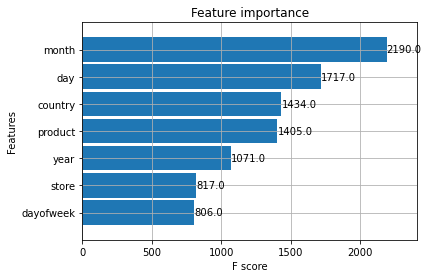

In [106]:
plot_importance(xgb, height=0.9)

In [107]:
cat_1 = CatBoostRegressor(verbose = 0, random_state = 42)
cat_1.fit(X_train, y_train)

In [108]:
vot = VotingRegressor(estimators=[('cat', cat_1), ('xgb', xgb), ('lgbm', lgbm)])
vot.fit(X_train, y_train)

VotingRegressor(estimators=[('cat',
                             <catboost.core.CatBoostRegressor object at 0x000002A79D31C400>),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=No...
                                          learning_rate=0.300000012,
                                          max_bin=256, max_cat_to_onehot=4,
                                          max_delta_step=0, max_depth=6,
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=150, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, ...)),
                            ('lgbm',
                             LGBMRegressor(application='regression',
                                           n_estimators=150,
                                           random_state=42))])

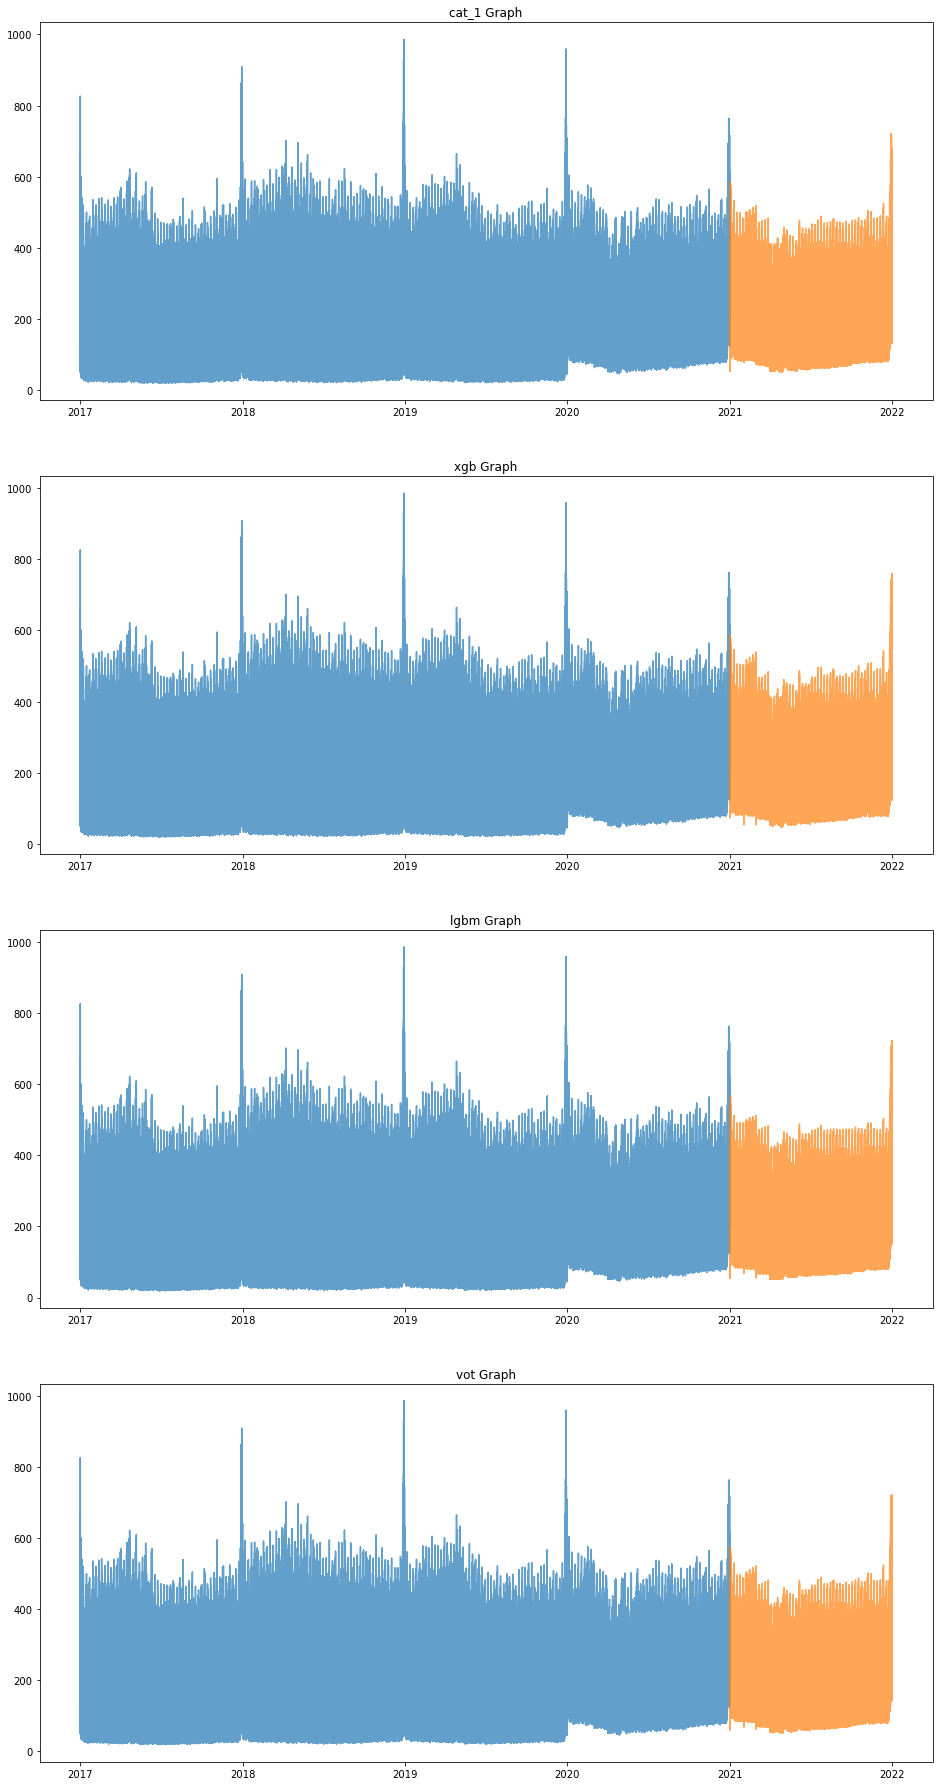

In [109]:
import matplotlib.pyplot as plt
cat_plot = cat_1.predict(test_drop)
xgb_plot = xgb.predict(test_drop)
lgbm_plot = lgbm.predict(test_drop)
vot_plot = vot.predict(test_drop)


plt.figure(figsize=(16,32))

plt.subplot(4, 1, 1)
plt.title('cat_1 Graph')
plt.plot(train['date'], y_train, test['date'], cat_plot, alpha = 0.7)

plt.subplot(4, 1, 2)
plt.title('xgb Graph')
plt.plot(train['date'], y_train, test['date'], xgb_plot, alpha = 0.7)

plt.subplot(4, 1, 3)
plt.title('lgbm Graph')
plt.plot(train['date'], y_train, test['date'], lgbm_plot, alpha = 0.7)

plt.subplot(4, 1, 4)
plt.title('vot Graph')
plt.plot(train['date'], y_train, test['date'], vot_plot, alpha = 0.7)
plt.show()

In [110]:
from sklearn.model_selection import cross_val_predict
print(cross_val_predict(cat_1, X_train, y_train, cv = 5).mean())
print(cross_val_predict(xgb, X_train, y_train, cv = 5).mean())
print(cross_val_predict(lgbm, X_train, y_train, cv = 5).mean())
print(cross_val_predict(vot, X_train, y_train, cv = 5).mean())

194.3012658345072
193.77687
193.5915674795427
193.88989649995926


In [111]:
# cross_val_predict(cat_2, X_train, y_train, cv = 10).mean()

In [112]:
# test_cate

In [113]:
predictions_1 = cat_1.predict(test_drop)
predictions_2 = xgb.predict(test_drop)
predictions_3 = lgbm.predict(test_drop)
predictions_4 = vot.predict(test_drop)
# predictions_2 = cat_2.predict(test_cate)

In [114]:
predictions_1

array([513.27130647, 413.6404031 , 365.56052815, ..., 170.64973478,
       145.37225435, 225.65943466])

In [115]:
predictions_2

array([510.30182, 420.24216, 362.55313, ..., 139.27776, 123.26744,
       201.01575], dtype=float32)

In [116]:
predictions_3

array([480.49699114, 372.53179627, 330.68293641, ..., 191.70324492,
       165.20368948, 237.85985877])

In [117]:
predictions_4

array([501.35670549, 402.13811878, 352.93219856, ..., 167.21024515,
       144.61446154, 221.51168017])

In [118]:
# predictions_2

In [119]:
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': predictions_4})
output.to_csv('cat_xgb_lgbm.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
